# 2.3 Titanic: Machine Learning from Disaster


In [1]:
#%config IPCompleter.greedy=True

In [2]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [4]:
from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

Считаем данные из датасета.

In [5]:
titanic_data = pd.read_csv('train.csv')

In [6]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Описание датафрейма:

+ PassengerId - id пассажира
+ Survived - выжил пассажир или нет
+ Pclass - класс биллета, который он приобрёл
+ Name - имя
+ Sex - пол
+ Age - возраст
+ SibSp - число сопутствующих с ним пассажиров
+ Parch - число родителей/детей на борту Титаника
+ Ticket - номер билета
+ Fare - 
+ Cabin - каюта, в которой он ехал
+ Embarked - Порт погрузки(C = Шербур, Q = Куинстаун, S = Саутгемптон)

**Задача: обучить дерево решений, которое будет предсказывать выжил пассажир или не выжил, основываясь на данных пассажиров из датасета train.csv.**

При работе с данными первым делом есть смысл сделать базовую предобработку. Чтобы понять с какими данными в принципе мы работаем.

Как минимум применить метод head() чтобы понять какого типа данные есть в датасете, визуально их рассмотреть. А ещё полезно посмотреть сколько пропущенных значений в колонках. Потому что если есть какие-то переменные, в которых 99% пропущенных значений, то скорее всего от них можно отказаться.

Как проверить в pandas наличие пропущенных значений в нашем датафрейме?

Во-первых, в pandas у датафрейма есть метод isnul(), возвращающий False или True для каждого наблюдения, в зависимости от того является ли наблюдение пропущенным.

In [8]:
titanic_data.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


Визуально, скорее всего не очень удобно воспринимать результат такой таблицы. Однако, если посчитать сумму, то результат уже можно использовать в работе.

Он будет содержать информацию о том сколько в каждой колонке находится пропущенных значений.

In [9]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Как видно из результатов выше - много данных потеряно о возрасте пассажиров и номерах кают, в которых они совершали путешествия.

Скорее всего в этом нет ничего страшного и для нас особого интереса переменная с номером каюты не представляет. Разве что она может содержть информацию о том где конкретно на Титанике находилась та или иная каюта. Пока для простоты исключим из рассмотрения данную переменную.

Это подталкивает нас к вопросу какие переменные мы будем использовать для обучения.

Повторюсь, сейчас мы не хотим останавливаться на задаче предобработки данных. Во-первых, мы обсудим это при работе с другими данными. Во-вторых, всё это можно посмотреть на [kaggle](kaggle.com), как делают это более скилованные ребята.

Поэтому давайте сейчас отберём только самые очевидные переменные, которые мы будем использовать для обучения и на них обучимся.

Итак, мы выкидаем из наблюдения следующие колонки:
+ Идентификатор пассажира
+ Номер билета
+ Номер каюты
+ Имя пассажира
+ Survived

Поскольку имя пассажира - это очень уникальная особенность конкретно взятого пассажираи использовать имя для вычисления некоторых закономерностей выглядит неразумно.

Survived удаляем не потому, что с ней что-то не так, а потому, что именно её мы и хотим предсказывать.

Как это можно сделать?

1. Сделать список тех фичей, которые нам нужно оставить, и тем самым создать новый датафрейм только с нужными колонками.
2. Из исходного датасета удалить ненужные колонки.

Давайте сделаем это вторым способом. Для этого используем метод `drop()`, передав в него список удаляемых колоной. Чтобы метод понял, что данный список содержит именно названия колонок, а не индексов нашего датафрейма, нужно задать ещё и аргумент axis=1.

In [10]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

Проверим, что всё удалилось.

In [11]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


Создадим переменную y, в которую положим ту переменную, которую мы будем предсказывать.

In [12]:
y = titanic_data.Survived

In [13]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## step 5

Что делать дальше мы уже знаем. Нам нужно дерево решений.

Создаём этот классификатор.

In [14]:
clf = tree.DecisionTreeClassifier()

И обучаем его на наших данных

In [15]:
# clf.fit(X, y)

```python
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-22-b0953fbb1d6e> in <module>
----> 1 clf.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py in fit(self, X, y, sample_weight, check_input, X_idx_sorted)
    875             sample_weight=sample_weight,
    876             check_input=check_input,
--> 877             X_idx_sorted=X_idx_sorted)
    878         return self
    879 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py in fit(self, X, y, sample_weight, check_input, X_idx_sorted)
    147 
    148         if check_input:
--> 149             X = check_array(X, dtype=DTYPE, accept_sparse="csc")
    150             y = check_array(y, ensure_2d=False, dtype=None)
    151             if issparse(X):

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py in check_array(array, accept_sparse, accept_large_sparse, dtype, order, copy, force_all_finite, ensure_2d, allow_nd, ensure_min_samples, ensure_min_features, warn_on_dtype, estimator)
    529                     array = array.astype(dtype, casting="unsafe", copy=False)
    530                 else:
--> 531                     array = np.asarray(array, order=order, dtype=dtype)
    532             except ComplexWarning:
    533                 raise ValueError("Complex data not supported\n"

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py in asarray(a, dtype, order)
     83 
     84     """
---> 85     return array(a, dtype, copy=False, order=order)
     86 
     87 

ValueError: could not convert string to float: 'male'
```

Мы поймали ошибку, связанную с преобразованием данных.

Оказывается в sklearn реализации дерева решений этот алгоритм может работать только с числовыми данными и даже номинативные переменные мы должны закодировать в виде числовых переменных при помощи 0, 1 или других чисел. А вот со строковыми идентификаторами работать, к сожалению, не получится.

Значит продолжаем процесс предобработки данных и избавляемся от переменных, записанных в строковом виде. Это интересная тема и существует несколько способов как это можно сделать.

Например, переменная Survived тоже является номинативной переменной, которая могла быть записана строками, а она записана 0 и 1. 

Вот такой способ кодировки номинативных переменных в количественные называется label incalling - когда мы присваиваем некоторму уровню просто некоторую градацию. Например male будет 0, а female будет 1. 

Это абсолютно допустимый вариант, особенно, когда мы работаем с деревьями решений. Потому что мы теперь будем говорить if Sex > 0.5 значит мы работаем в ситуации когда у нас один пол, а в другой ситуации - другой пол.

Либо есть другой способ one hot encoding когда мы переменную Sex разбиваем на две переменные - у нас будет переменная Sex male и Sex female. Они будут принимать значения либо 0, либо 1 в завиомости от того, что мы получаем.

Я подробнее расскажу о том какой способ предпочтительнее и есть ли предпочтительный способ для работы с деревом решений(забегая вперёд - нет, можно использовать оба).

Поэтому давайте сейчас воспользуемся вторым способом.

Можно добиться этого разными способами:
+ есть специальные методы в sklearn
+ в pandas есть метод get_dummies(), получающий на вход датафрейм и понимающий сам какие переменные нужно преобразовать в dummy variables, потому что если переменная записана в числовом виде, то он и не будет её трогать, а если переменная была записана в строковом виде - то переменная разобьётся на несколько

In [16]:
X = pd.get_dummies(X)

In [17]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Переменная Sex разбилась на Sex_male и Sex_female. А Embarked разбилась сразу на 3 переменные:
+ Embarked_C
+ Embarked_Q
+ Embarked_S


Про работу с категориальными признаками: Label Encoding, One-Hot Encoding можно почитать [здесь](https://habr.com/ru/company/ods/blog/326418/#label-encoding).

## step 6

Мы со всем разобрались и теперь в нашем датафрейме остались только числовые переменные. Причём есть переменные про пол, которые можно сказать себя дублируют.

В случае линейных моделей это могло бы привести к проблемам, но в случае с деревом решений - это не так страшно. Поэтому оставим всё как есть.

У нас есть X, готовый для передачи его в наше дерево решений. Давайте повторим попытку.

```python
clf.fit(X, y)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-15-afd4cda53619> in <module>
----> 1 clf.fit(X,y)

~\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self, X, y, sample_weight, check_input, X_idx_sorted)
    799             sample_weight=sample_weight,
    800             check_input=check_input,
--> 801             X_idx_sorted=X_idx_sorted)
    802         return self
    803 

~\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self, X, y, sample_weight, check_input, X_idx_sorted)
    114         random_state = check_random_state(self.random_state)
    115         if check_input:
--> 116             X = check_array(X, dtype=DTYPE, accept_sparse="csc")
    117             y = check_array(y, ensure_2d=False, dtype=None)
    118             if issparse(X):

~\Anaconda3\lib\site-packages\sklearn\utils\validation.py in check_array(array, accept_sparse, accept_large_sparse, dtype, order, copy, force_all_finite, ensure_2d, allow_nd, ensure_min_samples, ensure_min_features, warn_on_dtype, estimator)
    571         if force_all_finite:
    572             _assert_all_finite(array,
--> 573                                allow_nan=force_all_finite == 'allow-nan')
    574 
    575     shape_repr = _shape_repr(array.shape)

~\Anaconda3\lib\site-packages\sklearn\utils\validation.py in _assert_all_finite(X, allow_nan)
     54                 not allow_nan and not np.isfinite(X).all()):
     55             type_err = 'infinity' if allow_nan else 'NaN, infinity'
---> 56             raise ValueError(msg_err.format(type_err, X.dtype))
     57 
     58 

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').
```

Опять ошибка, но теперь другого рода - оказывается дерево решений не умеет работать с пропущенными значениями. 

Это можно было бы заподозрить ранее. поскольку непонятно как бы интерпретировать результаты вопросов, относящихся к переменной age, имеющей результаты NaN.

Что, кстати, зачастую является сильным недостатком этого метода.

Давайте решим и этот вопрос - заполним пропущенные значения, заодно посмотрим как лучше всего это сделать в pandas.

Вообще заполнение пропущенных значений - это отдельная большая тема. Забегая вперёд можно было бы сообразить, что мы же можем заполнить Age каким-то рандомным числом, а могли бы как-то обучить модель чтобы значения проставлялись "по уму". Но сейчас мы преследуем другие цели, поэтому давайте сделаем более простой вариант - заполним пропущенные значения медианным значением возраста.

Так вычисляется медиана

In [18]:
X.Age.median()

28.0

Запишем её теперь вместо пропусков

In [19]:
X = X.fillna({'Age':X.Age.median()})

Проверим, что всё теперь стало хорошо.

In [20]:
# 1 способ
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    uint8  
 6   Sex_male    891 non-null    uint8  
 7   Embarked_C  891 non-null    uint8  
 8   Embarked_Q  891 non-null    uint8  
 9   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.3 KB


In [21]:
# 2 способ
X.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

На этот раз всё готово для обучения нашего дерева. Давайте только для обучения будем использовать энтропию, раз уж мы с ней разобрались на прошлом занятии.

In [22]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [23]:
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Всё получилось!

Нетерпится посмотреть как же дерево решений смогло нам сказать - какие пассажиры у нас предсказываются как погибшие, какие - как выжившие. Какую закономерность этих данных мы смогли извлечь.

## step 7

Мы сделали всё "по инструкции" и теперь давайте посмотрим как же дерево решений воспользовалось нашими фичами, которые мы нагенерили, и построило понятное(как мы надеемся) дерево решений.

Посмотрим - чему наше дерево решений научилось.

In [24]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Users/kes/Anaconda3/Library/bin/graphviz' # (укажите свой путь до bin для graphviz)

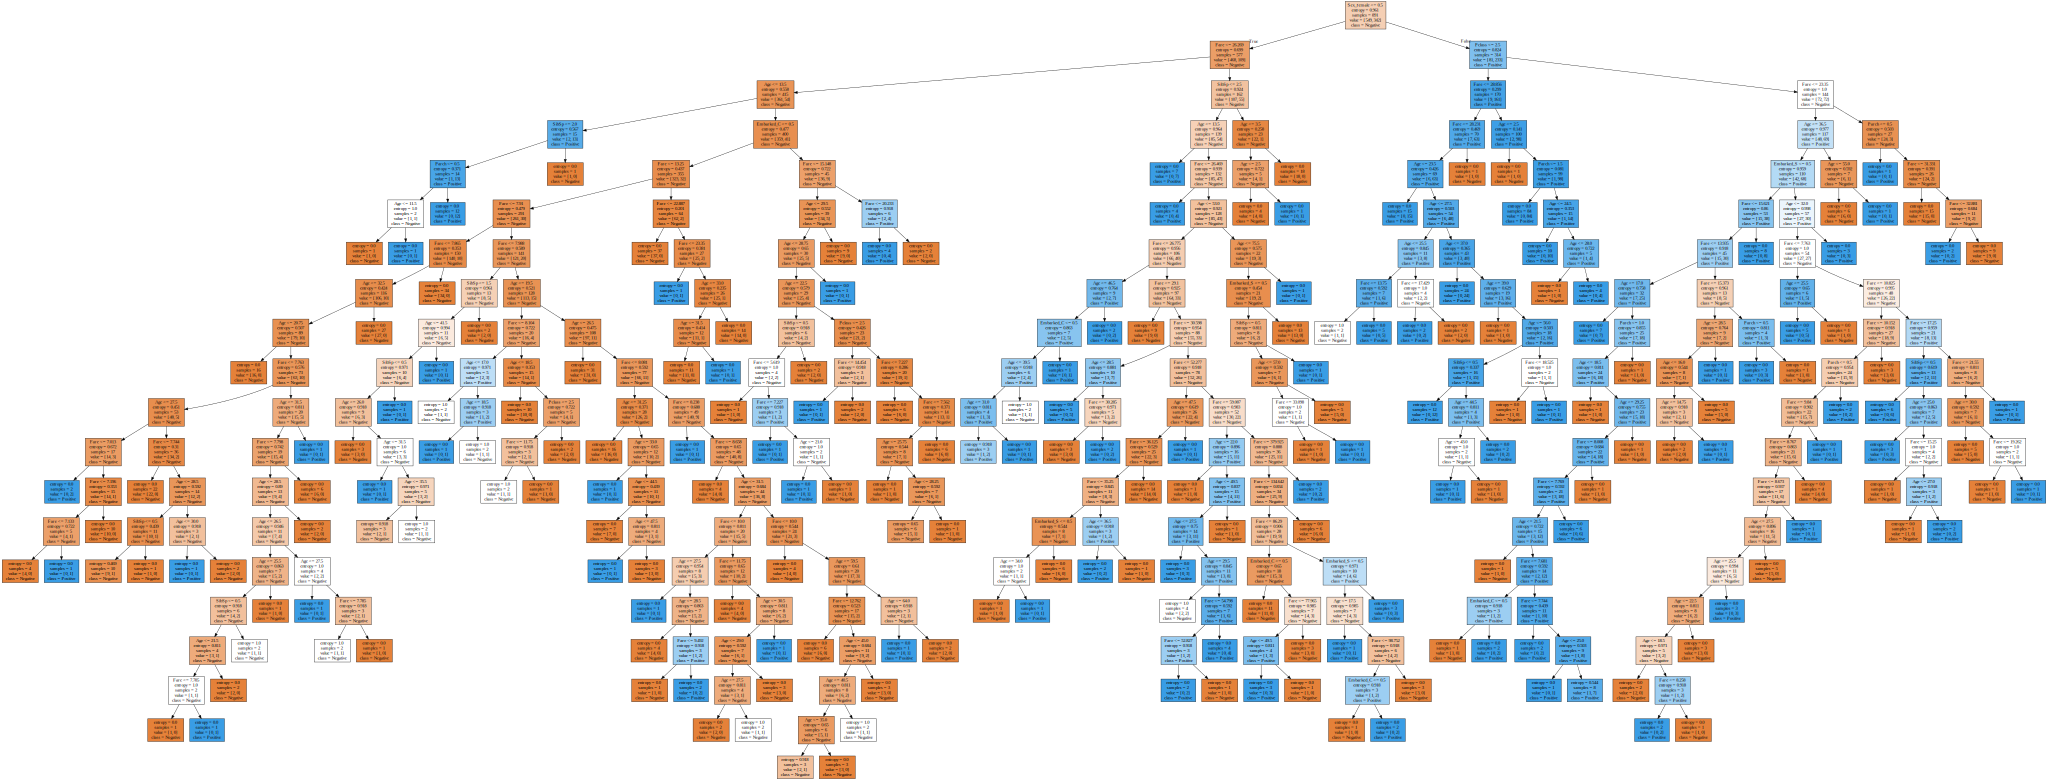

In [25]:
import sklearn
graph = Source(sklearn.tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Negative','Positive'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

Что это такое?

Это вообще непохоже на сколько-нибудь вменяемую конструкцию классификации пассажиров Титаника на то выжили они или нет.

Может с X что-то случилось?

In [26]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Нет. Всё ок - тот же набор фичей.

Но почему наше дерево решений представляет собой огромный набор логических проверок, которые нужно сделать, чтобы классифицировать наши наблюдения.

Выглядит очень странно.

Как минимум не такое дерево решений мы ожидали увидеть.

Посмотрим на наше получившееся дерево - в самом начале у нас 891 пассажир, 549 - погиб, 342 - выжило.

Первый вопрос про пол, а далее какое-то бесконечное количество комбинаций всех переменных, которые просто не помещаются в один экран и кажется, что что-то пошло не так.

## step 8

Так что же именно пошло не так? Почему наше дерево решений так разрослось до огромных размеров? 

И кажется, что те взаимосвязи которые оно выстроило - усложнены, и человек решил бы всё явно проще. 

Что случилось?

Случилась интересная штука. Мы примерно разобрали как устроен математический аппарат дерева решений и какой алгоритм там используется. Дерево решений не ставит своей целью вычленить какой-то паттерн, какую-то общую закономерность, которую можно использовать как некоторое генерализированное правило.

Помните с самого начала курс мы говорили о том, что такое обучиться чему-то? Например, научить ребенка отличать кошек от собак. Мы показываем ему 15 кошек и 15 собак и задача ребенка не отличать конкретно этих 15 кошек и 15 собак, а вычислить закономерность из этих 30 примеров и затем отличать между собой любых кошек и собак.

А в дереве решений, которое мы описали, это никак не заложено. Всё что делает дерево решений это говорит - пока я могу ещё снизить энтропию я буду снижать энтропию и разделять кошек от собак, кошек от собак до тех пор, пока все кошки не будут классифицированы как кошки, а собака - как собаки. И это далеко не то же самое, что вычленить общую закономерность.

Подытожим всё вышесказанное. То что мы наблюдали называется **переобучение** или **overfitting нашей модели**.

Мы сказали нашей модели не **вычлени закономерность в нашей модели, которая разделяет наших пассажиров на: выжил/не выжил**, а мы сказали дереву **вот тебе наш датафрейм, вот переменная y - сделай такое дерево решений, которое безошибочно классифицирует все наблюдения в нашем датафрейме**.

Как только мы спускаемся всё ниже и ниже у нас возникают новые неопределённости.

То есть дерево решает задачу классификации конкретно этих данных, не вычленяя при этом какое-то правило.Почему так происходит разберёмся ниже.

## step 9

Итак, разберёмся с тем - почему наше дерево получилось таким глубоким.

В нашем классификаторе есть параметр max_depth, который в нашем примере задан как None, т.е. наше дерево может расти сколько угодно.

Почему же это привело к таким результатам?

Пусть у нас есть набор данных: крестики и кружочки

![датасет](img/dataset.png)

Мы хотим наше дерево решений научить классифицировать крестики и кружочки. 

У нас есть две переменные: X1 и X2 и тип - крестики или кружочки. 

Дерево решений смотрит наши данные, пробегается по двум нашим фичам и находит первый оптимальный сплит.

Допустим первый сплит будет таким

![первый сплит](img/first_split.png)

Что происходит в этом случае?

Изначально у нас было 7 крестиков и 9 кружочков:

![исходное состояние](img/first.png)

Мы делаем первый сплит - говорим "правда ли, что x1 > n", где n - некоторый показатель.

Если это так, тогда у нас остаются только одни кружочки в количестве 7 штук. Это хорошо, т.к. энтропия в этом случае будет равна 0. Но если x1 < n - то у нас будет 7 крестиков и 2 кружка.

![сплит](img/split.png)

Для того, чтобы их рассплитить дерево решений делает ещё один сплит, например, такой:

![второй сплит](img/second_split.png)

И это будет, скажем, m.

Тогда, если X2 будет больше, чем m - у нас всё будет хорошо. Потому что если это так у нас остаются только кружочки, а если нет - только крестики.

![сплит 2](img/split2.png)

И вот такое дерево показывает некоторую закономерность, которую можно было бы использовать, визуализировать, проговорить, чтобы разделить крестики и кружочки.

Самое интересное начинается когда один кружочек проникнет в центр крестиков.

![](img/at_damn.png)

Дереву решеий теперь не будет покоя до самого конца происходящего. Оно говорит: "стоп, у нас есть кружочек и мы не остановимся в своем углублении до тех пор, пока этот кружочек не победим."

Как будем побеждать?

Давайте сделаем сплит, отбросив 3 крестика

![](img/split3.png)

Справа у нас будут только крестики, а вот слева по-прежнему останется кружок. Нужен ещё сплит.

![](img/split4.png)

Это тоже не до конца решает проблему - справа у нас 2 крестика, а слева по-прежнему остаётся 1 кружок среди 2 крестиков. Нужен ещё сплит.

![](img/final.png)

То есть для того чтобы победить 1 точку, нарушающую общую закономерность, мы взяли и нарастили дерево. Мы потратили столько же глубины дерева сколько потратили на почти все наши данные безошибочно классифицированные всего лишь с одним пропущенным неправильным угадыванием в нашем дереве.

![](img/add.png)

Для того чтобы увидеть эту одну ошибочную точку мы сделали ещё 3 сплита. 

А что было бы если бы среди кружочков при этом ещё был бы крестик? Дерево разросталось бы и там. В этом и есть алгоритм дерева - мы как бы говорим ему: "Дерево, пока у тебя есть возможность снизить энтропию - найди оптимальный сплит, просплиться по нему и посмотри, что дальше".

И вот здесь возникает интересная штука.

Когда мы говорим об общей закономерности, нам зачастую не так важно добиться 100% точности классификации, потому что в большинстве случаев, когда мы говорим про реальные задачи классификации у нас бывают такие ситуации:

![](img/real.png)

Есть два класса, между ними можно провести разделительную поверхность, но у нас довольно часто, просто в силу того, что никогда не бывает идеальной 100% точности, никогда нельзя ожидать, что два класса будут разделены 100%-но. 

То есть для реального мира вот такое разделение было бы хорошим, максимально правильным решением.

![](img/answer.png)

А вот заниматься выискиванием стопроцентного описания каждой такой отдельной ситуации - неправильно. Поскольку наша кривая, описывала бы отлично только одну выборку данных, а для другой выборки уже пришлось бы описывать новую кривую. А примерное решение, допускающее небольшую ошибку (чёрная прямая на предыдущем и следующем рисунках) достаточно хорошо разделила бы классы и на новых данных.

![](img/100.png)

Это и называется переобучением. Когда вместо того чтобы вычленить какую-то более общую закономерность мы занимаемся тем, что пытаемся безошибочно классифицировать каждое наблюдение в нашей выборке. Что далеко не всегда является необходимостью.

<font color=grey>"И мы не остановимся в своём углублении, пока этот кружочек не победим!"

(с) Дерево решений</font>

## step 10

Почему наше дерево так сильно разрастается, мы разобрались. Потому что дерево "из коробки" не ставит задачу вычленить общую закономерность, правило, закон природы, которое мы дали ему в наших данных. Оно пытается безошибочно классифицировать каждое наблюдение.

Первый вопрос - что с этим делать?

Нам нужно проверить, что наша закономерность, проверенная на нашей выборке, хорошо работает и на новых данных. 

То есть мы прогоняем дерево решений на новых данных и сравниваем предсказанные значения с их реальными значениями. Это позволит нам проверить правильно или нет работает наша модель.

Второй вопрос - как добиться того, чтобы дерево решений решало другую задачу? Именно задачу вычленения общей закономерности.

Здесь нам на помощь приходит концепция подбора параметров. 

У нашего дерева решений есть параметр, который мы можем безболезненно варьировать - глубина дерева. То есть мы можем ограничить количество вопросов, которое дерево может задать нашим данным. 

Что это означает на практике?

Мы говорим дереву: "Смотри у тебя есть Титаник. Ты умеешь правильно подбирать вопросы для снижения энтропии, но у тебя есть только 5 вопросов. Твоя задача задать всего 5, но самых главных вопросов, которые опишут почему одни люди на Титанике умирают, а другие нет".

Именно такой подход ограничения глубины роста дерева вниз отчасти решает нашу проблему переобучения. Потому что когда мы переформулировали задачу дереву: "У тебя есть некоторе ресурсы - воспользуйся ими максимально эффективно".

Посмотрим, как это работает на практике.

##  step 11

Итак, у нас есть 2 идеи:

+ Научиться ограничивать дерево в его стремлении расти как можно глубже
+ Нашему дереву показывать два набора данных:
    + данные, на которых наше дерево обучится
    + данные, на которых дерево протестируется
    
Для этого нам потребуется специальный метод `train_test_split` - удобная функция, получающая на вход датафрейм X с фичами, датафрейм y и разбивает их в заданной пропорции на тестовую и обучающую выборки.

tes_size = 0.33 значит:
+ 33% данных уйдут в тестовую выборку
+ остальное - в обучающую

In [27]:
from sklearn.model_selection import train_test_split 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# random_state это параметр генератора случайных чисел, который позволяет при каждом вызове 
# разбивать выборку одинаковым образом.

X_train - всё тот же наш датафрейм

In [29]:
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
6,1,54.0,0,0,51.8625,0,1,0,0,1
718,3,28.0,0,0,15.5000,0,1,0,1,0
685,2,25.0,1,2,41.5792,0,1,1,0,0
73,3,26.0,1,0,14.4542,0,1,1,0,0
882,3,22.0,0,0,10.5167,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
106,3,21.0,0,0,7.6500,1,0,0,0,1
270,1,28.0,0,0,31.0000,0,1,0,0,1
860,3,41.0,2,0,14.1083,0,1,0,0,1
435,1,14.0,1,2,120.0000,1,0,0,0,1


только наблюдений у него будет уже 596.

In [30]:
X_train.shape

(596, 10)

In [31]:
X_test.shape

(295, 10)

Аналогично и с y.

Вернёмся к нашей задаче - убедимся, что у нас есть проблемы с тем деревом, которое мы получили. Потому что на самом деле тот факт, что наше дерево глубокое и большое вообще в каком-то смысле может и не сигнализировать о проблеме.

Может быть закономерность настолько сложная, что описать её деревом меньших масштабов никак не получится. Давайте это проверим.

Проверить это можно сравнив насколько хорошо наше дерево предсказывает правильные ответы на обучающей выборке(train множестве) и насколько хорошо - на тестовой. Это очень упрощённая версия валидации модели.

У классификатора есть метод score, предсказывающий число правильных ответов.

In [32]:
clf.score(X, y)

0.9797979797979798

В 97% случаев мы правильно классифицировали все наши наблюдения на обучающей выборке.

А что если мы возьмём наш классификатор и обучим его на обучающей выборке.

In [33]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Посмотрим какая у нас точность предсказания на обучающей выборке

In [34]:
clf.score(X_train, y_train)

0.9798657718120806

А теперь посмотрим на тестовой выборке, на тех данных, которые наш классификатор не видел.

In [35]:
clf.score(X_test, y_test)

0.7762711864406779

Здесь нужно обратить внимание на большую разницу в полученных значениях на обучащей и тестовой выборках.

Большая разница в значениях говорит об overfitting

ограничим глубину дерева:

In [36]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)

In [37]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [38]:
clf.score(X_train, y_train)

0.8406040268456376

На знакомых данных классификатор стал работать хуже. Посмотрим как измениласт ситуация с незнакомыми данными

In [39]:
clf.score(X_test, y_test)

0.8067796610169492

Снизим глубину дерева и посмотрим на результат:

In [40]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)

In [41]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [42]:
clf.score(X_train, y_train)

0.8238255033557047

In [43]:
clf.score(X_test, y_test)

0.8203389830508474

Вот всегда так, изучаешь алгоритмы, машинного обучения, а оказывается вот в чем [реальная причина](https://vk.com/glazslov?w=wall-71343900_24281)!

### О РОЛИ ГЛАСНЫХ

Студенты, которые изучают статистику по всему миру, наверняка знакомы с таблицей, содержащей сведения о пассажирах «Титаника». Она хороша тем, что позволяет практиковаться в разных методах работы с данными, поскольу, во-первых, довольно велика (1313 записей), а во-вторых, включает разные типы переменных: имя пассажира, его пол, возраст, класс каюты, а также информацию о том, выжил он при катастрофе или погиб. Возможно, этически это и сомнительно, но дидактически очень удобно.

Как использовать этот ужасно-прекрасный материал для лингвистических целей?

Мы решили узнать, влияет ли как-то количество гласных в имени человека на его шансы выжить при кораблекрушении.

Возможно, это покажется вам удивительным (и клянемся чем угодно, что не врем), но построенная нами модель бинарной логистической регрессии оказалась не только статистически значимой (Pr(> chi2) <0.0001), но и способной объяснить более 70 % всего объема варьирования!

Итак, внимание: каждая дополнительная гласная в имени пассажира увеличивает шансы его спасения в Атлантическом океане в 1.35 раза. Только посмотрите на прикрепленный график.

В общем, если бы на «Титанике» оказались одновременно Дмитрий Николаевич Овсянико-Куликовский и, скажем, Лев Владимирович Щерба, первый практически наверняка бы выжил, а второй — гарантированно утонул.

# 2.4 Обучение, переобучение, недообучение и кросвалидация

В этом уроке мы узнаем, как валидировать модель при помощи [кросвалидации](https://scikit-learn.org/stable/modules/cross_validation.html), и что мы говорим богу переобучения.

### эффективный подбор параметров

In [44]:
max_depth_values = range(1, 100)

In [45]:
scores_data = pd.DataFrame()

In [46]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [47]:
scores_data

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.810169
...,...,...,...
0,95,0.979866,0.779661
0,96,0.979866,0.776271
0,97,0.979866,0.776271
0,98,0.979866,0.766102


Нужно преобразовать scores_data так, чтобы для каждой строки были созданы 2 новые: одна со значением точности на тренировочных данных, другая на тестовых. В новом scores_data_long (он long, потому что в нем в два раза больше строк) останется колонка max_depth, которую мы будем использовать как x и появится всего одна колонка score, которую будем использовать как y. Дополнительная третья колонка set_type разделит строки для отрисовки двух линий.

https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.melt.html

In [48]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name='set_type', value_name='score')

In [49]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


https://stackoverflow.com/questions/51422146/install-the-latest-version-of-seaborn-0-9-0-through-pip

pip3 install seaborn==0.9.0

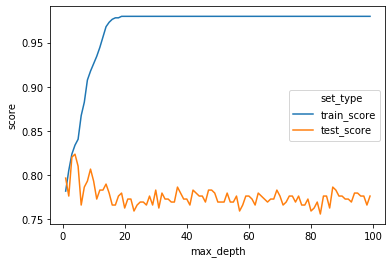

In [50]:
sns.lineplot(x='max_depth', y = 'score', hue = 'set_type', data = scores_data_long)

#### анализ графика:
- с увеличеним глубины дерева растет точность классификации на тренировочной выборке
- но это не всегда ведет к нахождению общих закономерностей исследуемых данных
- test score изначально невелик(модель еще не доучилась), на промежутке 3-5 score максимален(оптимальное состояние: закономерность с изученных данных переносится на новые), но в дальнейшем с увеличеним train score начинает падать test score(переход от недообученности к переобученности)

Так выглядит возможный пример дерева с параметром максимальной глубины равным 3. Легко можно заметить, что особенно важными переменными для анализа является пол и возраст. Кстати, про то, как при помощи дерева решений вычленить фичи, максимально важные для решения конкретной задачи классификации, мы подробнее поговорим в 3 модуле курса.

Тут же обратите внимание на еще один важный момент, если бы к нам поступил новый пассажир, и мы бы захотели, предсказать для него не только значение класса но и вероятность, того что он выживет на Титанике, это было бы несложно сделать при помощи нашего дерева. Обратите внимание, цвет финальных прямоугольничков различается, соотношение выживших/погибших пассажиров различается в финальных исходах - прямоугольничках. 

Например, если бы к нам пришло новое наблюдение Sex_male <=0.05, Pclass <= 2.5, Age > 2.5,  то предсказанная вероятность выжить была бы равна 102 / (102 + 3), то есть 97%. 

Но давайте сразу поймем, что с нашим деревом не так? Обратите внимание, что данное дерево все равно выглядит переобученным, например, есть разделение, которое приводит к тому, что под условие Age <= 2.5 проходит всего два наблюдения с разными классами, запомним эту проблему деревьев и вернемся к ней позже.

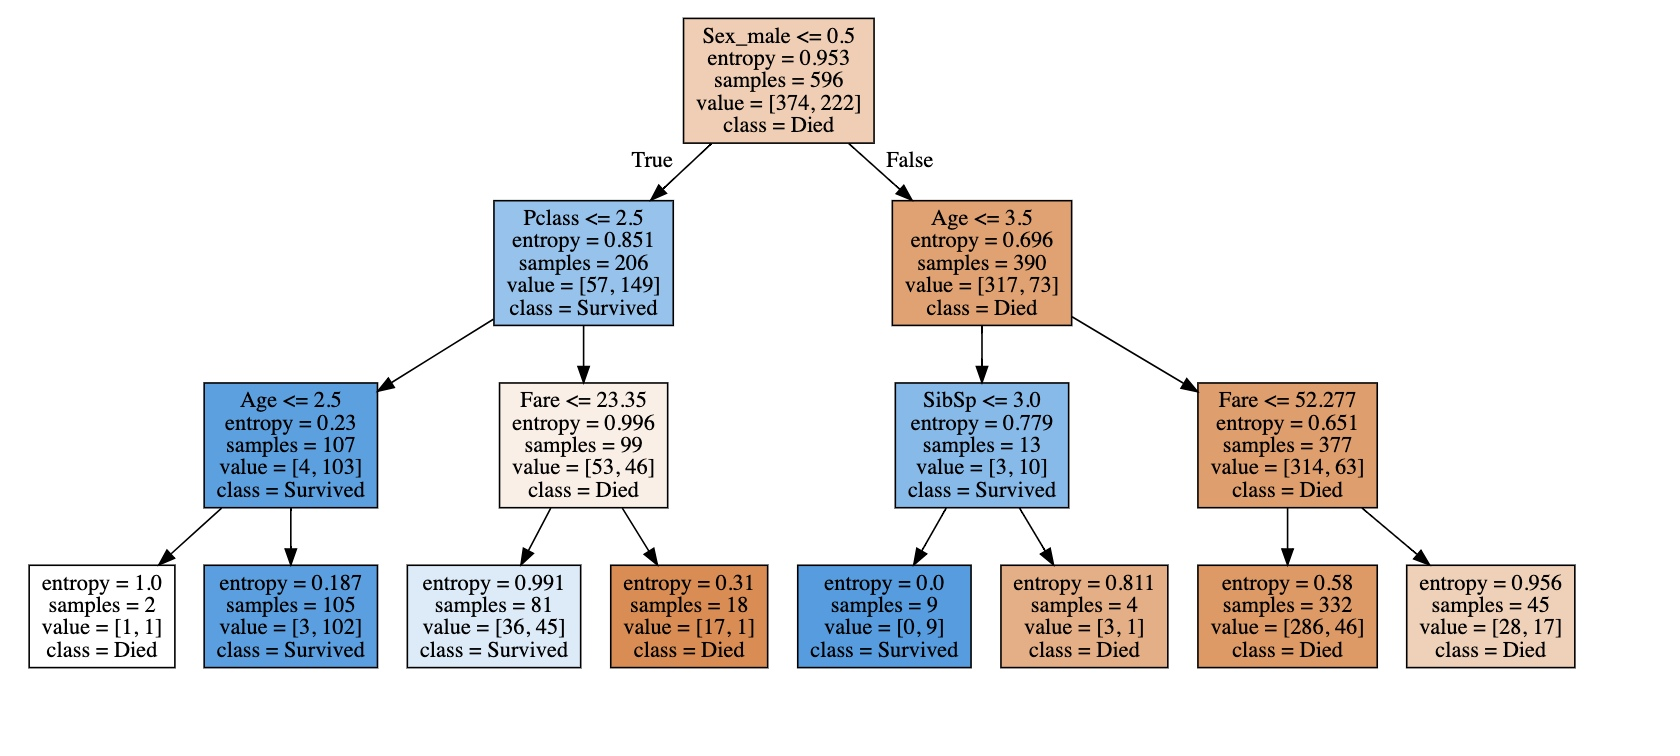


Выберите все подходящие ответы из списка

- [ ] Чем больше данных, тем больше вероятность переобучиться
- [x] Уменьшить переобученность поможет больший объём данных
- [x] Упрощение модели препятствует переобучению
- [x] Чем сложнее закономерности в данных, тем более сложная нужна модель для их поиска
- [x] Переобученная модель - модель, погрязшая в особенностях тренировочного датасэта, вместо вникания в общие закономерности

Для чего нужно разделение на train, test и validation датасэты?

Выберите один вариант из списка

- [x] train dataset используется для тренировки модели, validation - для её проверки, тестовый датасет выступает как ещё один уровень проверки, которая происходит на не показанных модели ранее данных
- [ ] Вы знаете этих датасаентистов - чем сложнее, тем лучше
- [ ] Чем больше датасэтов, на которых последовательно проверяется модель после обучения на train, тем лучше модель
- [ ] train dataset используется для тренировки, а test - для проверки модели, validation dataset не нужен

https://scikit-learn.org/stable/modules/cross_validation.html

Перебирая различную глубину дерева на один и тех же тестовых данных, мы не решаем проблему переобучения. Исправить ситуацию поможет  кросс-валидация (перекрестная проверка), разбивающая данные на тренировочную выборку для обучения, валидирующее множество для подбора оптимальных параметров и тестовые данные для финального замера точности.

обучение на нескольких подвыборках выборках:

In [51]:
from sklearn.model_selection import cross_val_score

1. Разделяем данные (X_train, y_train) на 5 частей, чтобы одну часть(всегда разную) использовать как тестовые данные, а остальные 4 как тренировочные. Получится, что каждый кусок данных будет использован и в обучении, и в тесте. Для каждой модели усредним accuracy на подвыборках, чтобы потом использовать как единый показатель точности для сравнения разных моделей.

In [52]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)

In [53]:
cross_val_score(clf, X_train, y_train, cv=5)

array([0.76666667, 0.82352941, 0.78991597, 0.75630252, 0.80672269])

In [54]:
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
6,1,54.0,0,0,51.8625,0,1,0,0,1
718,3,28.0,0,0,15.5000,0,1,0,1,0
685,2,25.0,1,2,41.5792,0,1,1,0,0
73,3,26.0,1,0,14.4542,0,1,1,0,0
882,3,22.0,0,0,10.5167,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
106,3,21.0,0,0,7.6500,1,0,0,0,1
270,1,28.0,0,0,31.0000,0,1,0,0,1
860,3,41.0,2,0,14.1083,0,1,0,0,1
435,1,14.0,1,2,120.0000,1,0,0,0,1


In [55]:
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.7886274509803922

2.  Возвращаемся к работе с циклом для поиска оптимальной глубины и добавляем в scores_data среднюю точность на кросс-валидации. (чтобы не было путаницы в одном ноутбуке переименуем  scores_data в cross_val_scores_data)

In [60]:
cross_val_scores_data = pd.DataFrame()

In [61]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train , cv=5).mean()
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'cross_val_score': [mean_cross_val_score],
                                    'test_score': [test_score]
                                    })
    cross_val_scores_data = cross_val_scores_data.append(temp_score_data)

In [63]:
cross_val_scores_data.head()

,max_depth,train_score,cross_val_score,test_score
0,1,0.781879,0.781961,0.796610
0,2,0.805369,0.770196,0.776271
0,3,0.823826,0.790322,0.820339
0,4,0.833893,0.788627,0.823729
0,5,0.840604,0.797031,0.806780


In [64]:
scores_data

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.810169
...,...,...,...
0,95,0.979866,0.779661
0,96,0.979866,0.776271
0,97,0.979866,0.776271
0,98,0.979866,0.766102


3. В результате получим датафрейм с колонкой  max_depth и тремя  score, аналогично шагу 3 этого урока, используя функцию melt, преобразуем данные и построим график:

In [65]:
cross_val_scores_data_long = pd.melt(cross_val_scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='set_type', value_name='score')

In [66]:
cross_val_scores_data_long

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604
...,...,...,...
292,95,cross_val_score,0.768501
293,96,cross_val_score,0.766821
294,97,cross_val_score,0.768501
295,98,cross_val_score,0.761779


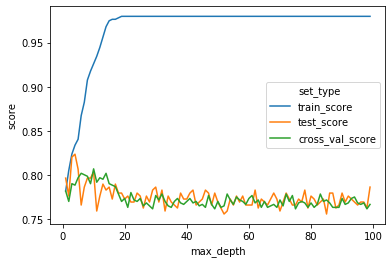

In [67]:
sns.lineplot(x="max_depth", y="score", hue="set_type", data=cross_val_scores_data_long)

4. Смотрим на зеленую линию (cross_val_score ). На графике ясно видно, что максимум приходится на глубину до 20. более точное значение максимальной глубины дерева поможет определить

In [68]:
cross_val_scores_data_long.query("set_type == 'cross_val_score'").head()

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.797031


In [69]:
cross_val_scores_data_long.sort_values('score', ascending=False).groupby('set_type').head(1)

,max_depth,set_type,score
62,63,train_score,0.979866
102,4,test_score,0.823729
207,10,cross_val_score,0.807073


In [70]:
cross_val_scores_data_long.query("set_type == 'cross_val_score'").score.max()

0.8070728291316526

5. Создаем классификатор, указывая соответствующее значение аргумента  max_depth. Обучаем на тренировочной выборке и замеряем точность на тестовой.

In [71]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [72]:
cross_val_score(best_clf, X_test, y_test, cv=5).mean()

0.7864406779661017

In [73]:
best_clf.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [74]:
best_clf.score(X_test, y_test)

0.8033898305084746

Подведем итоги:

1. Перекрестная проверка не возвращает модель: кросс-валидация не является способом построения модели, которую можно применить к новым данным. При вызове cross_val_score строится несколько внутренних моделей, однако цель перекрестной проверки заключается только в том, чтобы оценить обобщающую способность данного алгоритма, обучив на определенном наборе данных. ("Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными" А.Мюллер, С.Гвидо)


2. При k-fold кросс-валидации обучающая выборка разбивается на (k-1) подвыборок и следующий алгоритм выполняется k раз:
    - Модель обучается с использованием (k-1) подвыборок в качестве тренировочных данных;
    - Полученная модель проверяется на оставшейся одной подвыборке (которая служит тестовым набором для вычисления точности). 


3. Модель - это набор подготовленных данных (переменных) + метод (статистики, машинного обучения), подобранные для достижения цели исследования (проекта Data Science)
Процесс моделирования включает:
    - Создание модели - планирование показателей (переменных) и выбор метода
    - Тренировка модели
    - Проверка адекватности и окончательный выбор модели
    - Применение тренированной модели к незнакомым данным

Хорошая модель будет найдена (вероятно) только после многократного повторения первых 3-х шагов. ("Основы Data Science и Big Data. Python и наука о данных" Д.Силен, А.Мейсман, М.Али)

Таким образом:
1. Нужна хорошая модель, которая позволит достичь целей проекта, которую нужно обучить, протестировать, оценить и окончательно выбрать, после чего её можно будет применять "на производстве"
2. В данном уроке модель - это предобработанные данные Titanic + метод моделирования "Дерево решений", модель обучается методом fit() и тестируется 2-мя способами: score и cross_val_score
3. Метод cross_val_score() содержит (условно) процедуры обучения (fit) и проверки (score) , но он не может возвращать модель, которую можно применять к новым данным.

### Задача.
Убедимся в том, что всё так происходит на самом деле. Скачайте тренировочный датасэт с ирисами, обучите деревья с глубиной от 1 до 100. Целевой переменной при обучении является переменная species. При этом записывайте его скор (DecisionTreeClassifier.score()) на тренировочных данных, и аккуратность предсказаний (accuracy_score) на тестовом датасэте. Затем визуализируйте зависимость скора и аккуратности предсказаний от глубины дерева и выберите правильную визуализацию из предложенных.

Важно: задайте random seed прямо перед созданием дерева или укажите его в параметрах дерева (random_state=rs)

In [75]:
test_iris_df = pd.read_csv('test_iris.csv', index_col=0)
test_iris_df.head()

,sepal length,sepal width,petal length,petal width,species
114,5.8,2.8,5.1,2.4,2
70,5.9,3.2,4.8,1.8,1
138,6.0,3.0,4.8,1.8,2
59,5.2,2.7,3.9,1.4,1
44,5.1,3.8,1.9,0.4,0


In [76]:
test_iris_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 114 to 54
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  50 non-null     float64
 1   sepal width   50 non-null     float64
 2   petal length  50 non-null     float64
 3   petal width   50 non-null     float64
 4   species       50 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 2.3 KB


In [77]:
train_iris_df = pd.read_csv('train_iris.csv', index_col=0)
train_iris_df.head()

,sepal length,sepal width,petal length,petal width,species
130,7.4,2.8,6.1,1.9,2
7,5.0,3.4,1.5,0.2,0
11,4.8,3.4,1.6,0.2,0
142,5.8,2.7,5.1,1.9,2
109,7.2,3.6,6.1,2.5,2


In [78]:
train_iris_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 130 to 68
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  100 non-null    float64
 1   sepal width   100 non-null    float64
 2   petal length  100 non-null    float64
 3   petal width   100 non-null    float64
 4   species       100 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 4.7 KB


In [79]:
X_train_iris, y_train_iris = train_iris_df[['sepal length', 'sepal width', 'petal length', 'petal width']], train_iris_df['species']

In [80]:
X_test_iris, y_test_iris = test_iris_df[['sepal length', 'sepal width', 'petal length', 'petal width']], test_iris_df['species']

In [81]:
max_depth_values = range(1, 100)
rs = np.random.seed(0)
scores_data_iris = pd.DataFrame()

for max_depth in max_depth_values:
    clf_iris = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=rs)
    clf_iris.fit(X_train_iris, y_train_iris)
    train_score = clf_iris.score(X_train_iris, y_train_iris)
    accuracy_score = clf_iris.score(X_test_iris, y_test_iris)
    
    temp_score_data_iris = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'accuracy_score': [accuracy_score]})
    scores_data_iris = scores_data_iris.append(temp_score_data_iris)

In [82]:
scores_data_iris.head(5)

,max_depth,train_score,accuracy_score
0,1,0.70,0.60
0,2,0.97,0.94
0,3,0.99,0.94
0,4,1.00,0.92
0,5,1.00,0.92


In [83]:
sd_long = pd.melt(scores_data_iris, id_vars=['max_depth'], value_vars=['train_score', 'accuracy_score'], var_name='set_type', value_name='score')

In [84]:
sd_long.head(5)

,max_depth,set_type,score
0,1,train_score,0.70
1,2,train_score,0.97
2,3,train_score,0.99
3,4,train_score,1.00
4,5,train_score,1.00


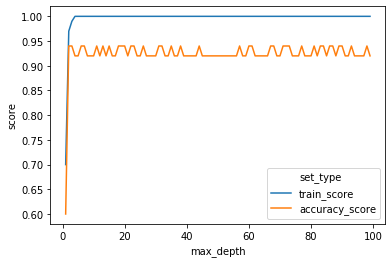

In [85]:
sns.lineplot(x='max_depth', y='score', hue='set_type', data = sd_long)

Тезисы:

1) **точность (score)** как процент правильных ответов не хорошая и не верная метрика качества модели. Например, в ситуации, когда только 10% выживших, любая модель-классификатор , которая бы всем (этот говорящий пример назовем "чтоб все утонули") предсказывала, что они не выживут, давала бы точность 90% , так как 10% выживших здесь, по сути, погрешность, равная доле неправильно классифицированных.

2) точность хорошо работает на сбалансированных выборках, т.е. когда наша переменная равномерно распределена между классами

3) получается, точность как доля верно классифицированных может быть разной для разных классов